# Загрузка Pandas и очистка данных

In [81]:
import pandas as pd
import ast
from bs4 import BeautifulSoup
import requests
import numpy as np
from multiprocessing import  Pool
from datetime import datetime, timedelta
from collections import namedtuple, Counter
from itertools import combinations
import random
from sklearn.preprocessing import OneHotEncoder
import seaborn as sns
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt

# this is just a file with a worker function for multiprocessing
# (otherwise multiprocessing doesn't work in Jupyter on Windows)
import worker  

%matplotlib inline

In [82]:
# Helper functions are defined in this cell

def drop_by_type(d, t):
    '''
    Drops columns of the dataframe based on their type
    Params:
        d - target dataframe
        t - type (from types returned by dtype) 
            provided as text (for example, 'float64')
    '''
    df_temp = d.copy()
    to_drop = [c for c in d.columns if t == str(d[c].dtype)]
    df_temp.drop(to_drop, axis=1, inplace=True)
    print(f"List of dropped columns (by type {t}): {to_drop}")
    return df_temp

'''
# These functions are in worker.py file now
def from_website(url):
    #print(f"https://www.tripadvisor.com{url}")
    r = requests.get(f"https://www.tripadvisor.com{url}", timeout=2)
    soup = BeautifulSoup(r.content)
    
    tmp = soup.find_all('span', {"class":"ratingDate"})
    rev_dates_lst = [i['title'] for i in tmp]
    #rev_dates_lst = [datetime.strptime(i['title'], '%B %d, %Y') for i in tmp]
    
    return rev_dates_lst


def apply_to_dataframe(df):
    df_result = df.copy()
    df_result['all_review_dates'] = df_result['URL_TA'].apply(from_website)
    return df_result
'''

def parallelize_dataframe(df, func, n_cores=30):
    df_split = np.array_split(df, n_cores)
    pool = Pool(n_cores)
    df = pd.concat(pool.map(func, df_split))
    pool.close()
    pool.join()
    return df


def create_freq_dict(d):
    '''
    Input dictionary must be sorted!
    
    This function takes dictionary with absolute frequencies as an argument
    and converts it into dictionary with relative frequencies percentages.
    
    For example, dictionary {'$$$$': 1423, '$': 6279, '$$ - $$$': 18412}
    will be turned into {'$$$$': 5.0, '$': 24.0, '$$ - $$$': 71.0}
    '''
    result = d
    tot = np.sum(list(d.values()))
    for k, v in d.items():
        d[k] = round(int(v) / tot * 100,0)
    
    return result


def fill_na_by_frequency(freq_dict, col):
    '''
    This function is used to replace NaN for categorical
    columns with values based on the frequency of non-missing values.

    For this function to work freq_dict (frequency dictionary) should be passed
    as an arguemnt. That's how frequency dictionary might look like (just an example)
    freq_dict: {'other': 7.0, 'father': 24.0, 'mother': 69.0}.
    Numbers correspond to the frequency of every possible distinct value.

    IMPORTANT: this function can't be applied using df.fillna() because the result
    must be different for every row it applies to, whereas fillna() replaces all NaN
    with a single value. Therefore apply() should be used on a column (series)
    '''

    random.seed(10)
    rnd_check = round(random.random()*100)    
    
    cumulative = 0
    for k, v in freq_dict.items():
        # cumulative is used to correctly assess the probability
        # for example, if we take {'other': 7.0, 'father': 24.0, 'mother': 69.0}
        # then "other" will be picked is rnd_check if <= 7, "father" will be
        # picked if rnd_check <= 31 and "mother" will be picked in al the other cases
        cumulative += v
        if rnd_check <= cumulative:
            #print(f'Random number is: {rnd_check}. Value is: {k}')
            return k
    # the last option
    return k
    #print(f'Random number is: {rnd_check}. Value is: {k}')
    
    
def convert_price_range(s):
    '''
    Converts price ranges provided as one of these values
    $
    $$ - $$$            
    $$$$
    to low, average and high 
    '''
    if s == '$':
        return 'low'
    elif s == '$$ - $$$':
        return 'average'
    elif s == '$$$$':
        return 'high'
    else:
        return 'other'

def median_interval(l):
    '''
    Takes a list with dates as strings in a format like 'February 28, 2017'
    and returns a median interval between 2 consequent dates in a dataset
    '''   
    #tmp = ast.literal_eval(l)
    tmp = l
    res_lst = []
    if len(tmp) > 1:
        tmp = [datetime.strptime(i, '%B %d, %Y') for i in tmp]
        i = 0
        for d in tmp:
            res_lst.append((tmp[i] - d).days)
        return np.median(res_lst)
    return 0

def restaurant_age(l, snapshot_date):
    '''
    Takes a list with dates as strings in a format like 'February 28, 2017'
    and returns a day difference between snapshot_date and the first review date
    (let's  consider that an estimate of restaurant age on Tripadvisor website)
    '''   
    #tmp = ast.literal_eval(l)
    tmp = l
    res_lst = []
    if len(tmp) > 0:
        tmp = [datetime.strptime(i, '%B %d, %Y') for i in tmp]
        return (snapshot_date - np.min(tmp)).days
    return 0

def is_weekend(l):
    '''
    Takes a list with dates as strings in a format like 'February 28, 2017'
    and returns the most frequent weekday when the review was left
    '''   
    #tmp = ast.literal_eval(l)
    tmp = l
    res_lst = []
    if len(tmp) > 0:
        tmp = [datetime.strftime(datetime.strptime(i, '%B %d, %Y'),'%A') for i in tmp]
        day = Counter(tmp).most_common(1)[0][0]
        if day.lower() in ['saturday','sunday']:
            return 1
        else:
            return 0    
    return 0

def get_stat_dif(column,  df_data):
    '''
    Student's t-test for all combinations of values for each categorical column
    '''
    cols = df_data.loc[:, column].value_counts().index
    combinations_all = list(combinations(cols, 2))
    for comb in combinations_all:
        if ttest_ind(df_data.loc[df_data.loc[:, column] == comb[0], 'Rating'],
                     df_data.loc[df_data.loc[:, column] == comb[1], 'Rating']).pvalue \
                <= 0.05/len(combinations_all):  # Bonferroni correction applied to avoid excessive amount of false negatives
            print('Statistically significant differences found for column:', column)
            return column   
    

In [83]:
df = pd.read_csv('main_task.xls')
df_small = df.iloc[:240,:] # I sometimes use it for testing
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      40000 non-null  object 
 1   City               40000 non-null  object 
 2   Cuisine Style      30717 non-null  object 
 3   Ranking            40000 non-null  float64
 4   Rating             40000 non-null  float64
 5   Price Range        26114 non-null  object 
 6   Number of Reviews  37457 non-null  float64
 7   Reviews            40000 non-null  object 
 8   URL_TA             40000 non-null  object 
 9   ID_TA              40000 non-null  object 
dtypes: float64(3), object(7)
memory usage: 3.1+ MB


In [84]:
df.head(10)

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_5569,Paris,"['European', 'French', 'International']",5570.0,3.5,$$ - $$$,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643
1,id_1535,Stockholm,NaN,1537.0,4.0,NaN,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032
2,id_352,London,"['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...",353.0,4.5,$$$$,688.0,"[['Catch up with friends', 'Not exceptional'],...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,d8632781
3,id_3456,Berlin,NaN,3458.0,5.0,NaN,3.0,"[[], []]",/Restaurant_Review-g187323-d1358776-Reviews-Es...,d1358776
4,id_615,Munich,"['German', 'Central European', 'Vegetarian Fri...",621.0,4.0,$$ - $$$,84.0,"[['Best place to try a Bavarian food', 'Nice b...",/Restaurant_Review-g187309-d6864963-Reviews-Au...,d6864963
5,id_1418,Oporto,NaN,1419.0,3.0,NaN,2.0,"[['There are better 3 star hotel bars', 'Amazi...",/Restaurant_Review-g189180-d12503536-Reviews-D...,d12503536
6,id_1720,Milan,"['Italian', 'Pizza']",1722.0,4.0,$,50.0,"[['Excellent simple local eatery.', 'Excellent...",/Restaurant_Review-g187849-d5808504-Reviews-Pi...,d5808504
7,id_825,Bratislava,['Italian'],826.0,3.0,NaN,9.0,"[['Wasting of money', 'excellent cuisine'], ['...",/Restaurant_Review-g274924-d3199765-Reviews-Ri...,d3199765
8,id_2690,Vienna,NaN,2692.0,4.0,NaN,NaN,"[[], []]",/Restaurant_Review-g190454-d12845029-Reviews-G...,d12845029
9,id_4209,Rome,"['Italian', 'Pizza', 'Fast Food']",4210.0,4.0,$,55.0,"[['Clean efficient staff', 'Nice little pizza ...",/Restaurant_Review-g187791-d8020681-Reviews-Qu...,d8020681


In [85]:
'''
# Uncomment it only if you need to crawl Tripadvisor website once again
if __name__ ==  '__main__': 
    df_crawled = parallelize_dataframe(df, worker.apply_to_dataframe)
    
df_crawled.to_csv('with_additional_data_from_TA_ALL_2.csv')    
'''

# this is a file that consists of an original dataframe 
# extended with additional data from Tripadvisor website
# using requests and beautifulsoup
df = pd.read_csv('with_additional_data_from_TA_ALL_2.csv')
df.drop(labels=['Unnamed: 0'], axis=1, inplace=True)
df.head()

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,all_review_dates
0,id_5569,Paris,"['European', 'French', 'International']",5570.0,3.5,$$ - $$$,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643,"['February 14, 2020', 'December 20, 2019', 'No..."
1,id_1535,Stockholm,NaN,1537.0,4.0,NaN,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032,[]
2,id_352,London,"['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...",353.0,4.5,$$$$,688.0,"[['Catch up with friends', 'Not exceptional'],...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,d8632781,"['September 25, 2020', 'September 5, 2020', 'A..."
3,id_3456,Berlin,NaN,3458.0,5.0,NaN,3.0,"[[], []]",/Restaurant_Review-g187323-d1358776-Reviews-Es...,d1358776,[]
4,id_615,Munich,"['German', 'Central European', 'Vegetarian Fri...",621.0,4.0,$$ - $$$,84.0,"[['Best place to try a Bavarian food', 'Nice b...",/Restaurant_Review-g187309-d6864963-Reviews-Au...,d6864963,"['September 10, 2020', 'September 28, 2019', '..."


In [86]:
# Given the fact that it's currently year 2020 and a dataset for the task contains
# an older data it would be wise to avoid using records that appeared after a maximal
# date available in this dataset (the ones I obtained using web crawling).
# Let's find this date
df['tst'] = df['Reviews'].map(lambda x: x.split("], [")[1])
df['tst'] = df['tst'].str.replace('[','').str.replace(']','').str.replace("'",'').str.replace("'",'').str.split(',')
task_snapshot_date = pd.to_datetime(df['tst'].explode()).max()
df.drop(labels=['tst'], axis=1, inplace=True)
print(f"Snapshot date: {task_snapshot_date}")

Snapshot date: 2018-02-26 00:00:00


In [87]:
# The data was saved to a file after web crawler (function from_website) was executed.
# It means that all_review_dates contains a string representation of a list.
# Let's convert it into the list to make other functions run faster
df['all_review_dates'] = df['all_review_dates'].map(ast.literal_eval)

# Let's remove all the review dates after task_snapshot_date
df['all_review_dates'] = df['all_review_dates'].map(lambda lst:\
    [i for i in lst if task_snapshot_date >= datetime.strptime(i, '%B %d, %Y')])

In [88]:
# let's drop Restaurant_id, ID_TA and URL_TA because we don't need them anymore
df.drop(labels=['Restaurant_id','ID_TA','URL_TA'], axis=1, inplace=True)
df.head(5)

,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,all_review_dates
0,Paris,"['European', 'French', 'International']",5570.0,3.5,$$ - $$$,194.0,"[['Good food at your doorstep', 'A good hotel ...","[January 13, 2018, December 31, 2017, November..."
1,Stockholm,NaN,1537.0,4.0,NaN,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",[]
2,London,"['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...",353.0,4.5,$$$$,688.0,"[['Catch up with friends', 'Not exceptional'],...","[May 12, 2014, May 6, 2014, May 5, 2014, May 4..."
3,Berlin,NaN,3458.0,5.0,NaN,3.0,"[[], []]",[]
4,Munich,"['German', 'Central European', 'Vegetarian Fri...",621.0,4.0,$$ - $$$,84.0,"[['Best place to try a Bavarian food', 'Nice b...","[November 18, 2017, July 25, 2017, May 16, 201..."


In [89]:
# Let's make sure that there's a statistically significant difference between 
# ratings for different values of categorical variables - I will work
# with them further if there is
get_stat_dif('City', df)
get_stat_dif('Price Range', df)

Statistically significant differences found for column: City
Statistically significant differences found for column: Price Range


'Price Range'

In [90]:
# let's create 2 simple columns to mimic a basic sentiment analysis
# first column will be 1 if a restaurant contains some negative review
# (like bad, awful, horrible, dirty, disgusting) in 2 reviews provided
# in a dataset
bad_words = "terrible|very bad|awful|horrible|dirty|disgusting|bad experience|don't go|bad service|unfriendly|not good|"\
    "disappointed|rubbish|average food|bad customer service|poor"
df['contains_bad_review'] = df['Reviews'].str.contains(bad_words, regex=True, case=False).astype(int)

# same but with good words 
good_words = "good|nice|amazing|best|great|excellent"
df['contains_good_review'] = df['Reviews'].str.contains(good_words, regex=True, case=False).astype(int)

df.head()

,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,all_review_dates,contains_bad_review,contains_good_review
0,Paris,"['European', 'French', 'International']",5570.0,3.5,$$ - $$$,194.0,"[['Good food at your doorstep', 'A good hotel ...","[January 13, 2018, December 31, 2017, November...",0,1
1,Stockholm,NaN,1537.0,4.0,NaN,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",[],0,0
2,London,"['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...",353.0,4.5,$$$$,688.0,"[['Catch up with friends', 'Not exceptional'],...","[May 12, 2014, May 6, 2014, May 5, 2014, May 4...",0,0
3,Berlin,NaN,3458.0,5.0,NaN,3.0,"[[], []]",[],0,0
4,Munich,"['German', 'Central European', 'Vegetarian Fri...",621.0,4.0,$$ - $$$,84.0,"[['Best place to try a Bavarian food', 'Nice b...","[November 18, 2017, July 25, 2017, May 16, 201...",0,1


In [91]:
df[['contains_bad_review','contains_good_review']].sum()

contains_bad_review      1498
contains_good_review    21001
dtype: int64

In [92]:
# determining unique cuisine styles and their value counts
# ast.literal_eval is required because lists of styles are
# represented as strings in the dataframe
# IMPORTANT: nan values are replaced by the fake list empty list "[]" for this
# particular part of the task, but that does not happen in place
df['cuisine_styles_num'] = df['Cuisine Style'].fillna("[]").apply(ast.literal_eval).apply(len)

In [93]:
# let's check the number of unique cuisine styles (empty records will be marked as
# a "no_style_provided" in place)
df['Cuisine Style'].fillna("['no_style_provided']", inplace=True)

unique_styles = df['Cuisine Style'].apply(ast.literal_eval).explode()\
    .value_counts(normalize=True)

sum(unique_styles.head(10)), unique_styles.head(10)

(0.580289048200122,
 Vegetarian Friendly    0.106668
 European               0.095905
 no_style_provided      0.088497
 Mediterranean          0.059840
 Italian                0.056856
 Vegan Options          0.042766
 Gluten Free Options    0.039210
 Bar                    0.031431
 French                 0.030411
 Asian                  0.028705
 Name: Cuisine Style, dtype: float64)

In [94]:
# Let's take top 10 styles and create binary variables out of them
# (for example, European can be either 0 or 1).
for c in list(unique_styles.head(10).index):
    df[c] = df['Cuisine Style'].str.contains(c, regex=False).astype(int)
df.head(10)

,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,all_review_dates,contains_bad_review,contains_good_review,...,Vegetarian Friendly,European,no_style_provided,Mediterranean,Italian,Vegan Options,Gluten Free Options,Bar,French,Asian
0,Paris,"['European', 'French', 'International']",5570.0,3.5,$$ - $$$,194.0,"[['Good food at your doorstep', 'A good hotel ...","[January 13, 2018, December 31, 2017, November...",0,1,...,0,1,0,0,0,0,0,0,1,0
1,Stockholm,['no_style_provided'],1537.0,4.0,NaN,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",[],0,0,...,0,0,1,0,0,0,0,0,0,0
2,London,"['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...",353.0,4.5,$$$$,688.0,"[['Catch up with friends', 'Not exceptional'],...","[May 12, 2014, May 6, 2014, May 5, 2014, May 4...",0,0,...,1,0,0,0,0,1,1,0,0,1
3,Berlin,['no_style_provided'],3458.0,5.0,NaN,3.0,"[[], []]",[],0,0,...,0,0,1,0,0,0,0,0,0,0
4,Munich,"['German', 'Central European', 'Vegetarian Fri...",621.0,4.0,$$ - $$$,84.0,"[['Best place to try a Bavarian food', 'Nice b...","[November 18, 2017, July 25, 2017, May 16, 201...",0,1,...,1,1,0,0,0,0,0,0,0,0
5,Oporto,['no_style_provided'],1419.0,3.0,NaN,2.0,"[['There are better 3 star hotel bars', 'Amazi...","[September 16, 2017, May 31, 2017]",0,1,...,0,0,1,0,0,0,0,0,0,0
6,Milan,"['Italian', 'Pizza']",1722.0,4.0,$,50.0,"[['Excellent simple local eatery.', 'Excellent...","[January 27, 2018, November 5, 2017, August 4,...",0,1,...,0,0,0,0,1,0,0,0,0,0
7,Bratislava,['Italian'],826.0,3.0,NaN,9.0,"[['Wasting of money', 'excellent cuisine'], ['...",[],0,1,...,0,0,0,0,1,0,0,0,0,0
8,Vienna,['no_style_provided'],2692.0,4.0,NaN,NaN,"[[], []]",[],0,0,...,0,0,1,0,0,0,0,0,0,0
9,Rome,"['Italian', 'Pizza', 'Fast Food']",4210.0,4.0,$,55.0,"[['Clean efficient staff', 'Nice little pizza ...","[December 24, 2017, November 7, 2017, Septembe...",0,1,...,0,0,0,0,1,0,0,0,0,0


In [95]:
# let's consider NaN in number of reviews as 0
df['Number of Reviews'].fillna(0, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   City                  40000 non-null  object 
 1   Cuisine Style         40000 non-null  object 
 2   Ranking               40000 non-null  float64
 3   Rating                40000 non-null  float64
 4   Price Range           26114 non-null  object 
 5   Number of Reviews     40000 non-null  float64
 6   Reviews               40000 non-null  object 
 7   all_review_dates      40000 non-null  object 
 8   contains_bad_review   40000 non-null  int32  
 9   contains_good_review  40000 non-null  int32  
 10  cuisine_styles_num    40000 non-null  int64  
 11  Vegetarian Friendly   40000 non-null  int32  
 12  European              40000 non-null  int32  
 13  no_style_provided     40000 non-null  int32  
 14  Mediterranean         40000 non-null  int32  
 15  Italian            

In [96]:
df['City'].nunique()

31

In [97]:
# There are too many unique cities in the dataset (31) - therefore one hot encoding is not an option.
# Let's use worldcities dataset from https://www.kaggle.com/viswanathanc/world-cities-datasets
# I want to create 2 dimension from an original 'City' column: capital and  population
df_cities = pd.read_csv('worldcities.csv')

# leaving only required columns from worldcities data set
df_cities = df_cities[['city_ascii','capital','population']]

# the assumption here is that most of the capitals will be listed as primary
# and we don't really care about other classification because the variable will be
# binary in the end (capital = 0 or 1)
df_cities['capital'].fillna('other', inplace=True) 

# the assumption here is that most important cities will have the population
# mentioned in the data set
df_cities['population'].fillna(0, inplace=True)

# leaving only cities with max population - this will eliminate duplicates
# in case multiple cities with the same name exist
df_cities.sort_values(by=['city_ascii','population'], ascending=[True,False], inplace=True)
df_cities.drop_duplicates(subset='city_ascii', keep='first', inplace=True)

# making sure we have no more duplicates
df_cities['city_ascii'].value_counts()

Pollock Pines                 1
Rio Largo                     1
Fountainhead-Orchard Hills    1
Yonkers                       1
Tauranga                      1
                             ..
Westview                      1
Bayou Vista                   1
Battle Ground                 1
Marathon                      1
I`zaz                         1
Name: city_ascii, Length: 13482, dtype: int64

In [98]:
# modifying 'capital' column to make it binary (if capital then 1 else 0)
df_cities['capital'] = df_cities['capital'].map(lambda x : 1 if x == 'primary' else 0)
df_cities['capital'].value_counts()

0    13275
1      207
Name: capital, dtype: int64

In [99]:
# merging df with df_cities based on city name
df = df.merge(df_cities, how='left', left_on='City', right_on='city_ascii')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40000 entries, 0 to 39999
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   City                  40000 non-null  object 
 1   Cuisine Style         40000 non-null  object 
 2   Ranking               40000 non-null  float64
 3   Rating                40000 non-null  float64
 4   Price Range           26114 non-null  object 
 5   Number of Reviews     40000 non-null  float64
 6   Reviews               40000 non-null  object 
 7   all_review_dates      40000 non-null  object 
 8   contains_bad_review   40000 non-null  int32  
 9   contains_good_review  40000 non-null  int32  
 10  cuisine_styles_num    40000 non-null  int64  
 11  Vegetarian Friendly   40000 non-null  int32  
 12  European              40000 non-null  int32  
 13  no_style_provided     40000 non-null  int32  
 14  Mediterranean         40000 non-null  int32  
 15  Italian            

In [100]:
# let's see what cities are missing
df[df['capital'].isna()]['City'].value_counts()

Oporto    513
Name: City, dtype: int64

In [101]:
# it seems that we're missing the data about only one city - Oporto (aka Porto in Portugal)
# let's locate it and populate missing values manually
df['capital'].fillna(0, inplace=True)
df['population'].fillna(1337000, inplace=True)

In [102]:
# let's drop some columns that are not required anymore
# to make the dataframe more compact and readable
df.drop(['city_ascii', 'City', 'Cuisine Style', 'Reviews'], axis=1, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40000 entries, 0 to 39999
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Ranking               40000 non-null  float64
 1   Rating                40000 non-null  float64
 2   Price Range           26114 non-null  object 
 3   Number of Reviews     40000 non-null  float64
 4   all_review_dates      40000 non-null  object 
 5   contains_bad_review   40000 non-null  int32  
 6   contains_good_review  40000 non-null  int32  
 7   cuisine_styles_num    40000 non-null  int64  
 8   Vegetarian Friendly   40000 non-null  int32  
 9   European              40000 non-null  int32  
 10  no_style_provided     40000 non-null  int32  
 11  Mediterranean         40000 non-null  int32  
 12  Italian               40000 non-null  int32  
 13  Vegan Options         40000 non-null  int32  
 14  Gluten Free Options   40000 non-null  int32  
 15  Bar                

In [103]:
# let's take a look at price ranges
df['Price Range'].value_counts()

$$ - $$$    18412
$            6279
$$$$         1423
Name: Price Range, dtype: int64

In [104]:
# it seems there are many NaN values among price ranges
# let's replace NaN with values based on a frequency of the existing values
# custom function will be used for that (see definition of helper functions above)

# please note that ascending=True is important here because the dictionary must be sorted
freq_dict = create_freq_dict(dict(df['Price Range'].value_counts(ascending=True)))
df['Price Range'] = df['Price Range'].apply(
    lambda x: fill_na_by_frequency(freq_dict, "Price Range") if pd.isna(x) else x)
# also let's make Price Range names more meaningful (before we one hot encode them)
df['Price Range'] = df['Price Range'].apply(convert_price_range)

In [105]:
# let's take a look at price ranges once again - it seems that there are
# no more missing values
df['Price Range'].value_counts()

average    32298
low         6279
high        1423
Name: Price Range, dtype: int64

In [106]:
# and there are no more missing values in the dataframe as such
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40000 entries, 0 to 39999
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Ranking               40000 non-null  float64
 1   Rating                40000 non-null  float64
 2   Price Range           40000 non-null  object 
 3   Number of Reviews     40000 non-null  float64
 4   all_review_dates      40000 non-null  object 
 5   contains_bad_review   40000 non-null  int32  
 6   contains_good_review  40000 non-null  int32  
 7   cuisine_styles_num    40000 non-null  int64  
 8   Vegetarian Friendly   40000 non-null  int32  
 9   European              40000 non-null  int32  
 10  no_style_provided     40000 non-null  int32  
 11  Mediterranean         40000 non-null  int32  
 12  Italian               40000 non-null  int32  
 13  Vegan Options         40000 non-null  int32  
 14  Gluten Free Options   40000 non-null  int32  
 15  Bar                

In [107]:
# processing Price Range with one hot encoder
enc = OneHotEncoder(handle_unknown='ignore')
y = OneHotEncoder().fit_transform(df['Price Range'].to_numpy().reshape(-1, 1)).toarray()
# list(df['Price Range'].unique()) is safe because the values are provided 
# in order of appearance
df_price_rng = pd.DataFrame(y, columns=list(df['Price Range'].unique()))
df = pd.concat([df,df_price_rng], axis=1)
df.drop(['Price Range'], inplace=True, axis=1)

In [108]:
# let's calculate restaurant_age for every restaraunt and drop 'all_review_dates' column
df['restaurant_age'] = df['all_review_dates'].map(lambda x: restaurant_age(x, snapshot_date=task_snapshot_date))
# let's calculate median interval between consequetive review dates
df['median_interval'] = df['all_review_dates'].map(median_interval)
# let's determine if most reviews were left on weekend or a weekday
df['is_weekend'] = df['all_review_dates'].map(is_weekend)
df.drop(labels=['all_review_dates'], axis=1, inplace=True)
df.info()
print(f"Most popular restaurant age on a tripadvisor: {df['restaurant_age'].value_counts().index[0]}")

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40000 entries, 0 to 39999
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Ranking               40000 non-null  float64
 1   Rating                40000 non-null  float64
 2   Number of Reviews     40000 non-null  float64
 3   contains_bad_review   40000 non-null  int32  
 4   contains_good_review  40000 non-null  int32  
 5   cuisine_styles_num    40000 non-null  int64  
 6   Vegetarian Friendly   40000 non-null  int32  
 7   European              40000 non-null  int32  
 8   no_style_provided     40000 non-null  int32  
 9   Mediterranean         40000 non-null  int32  
 10  Italian               40000 non-null  int32  
 11  Vegan Options         40000 non-null  int32  
 12  Gluten Free Options   40000 non-null  int32  
 13  Bar                   40000 non-null  int32  
 14  French                40000 non-null  int32  
 15  Asian              

In [109]:
# let's split columns into numeric and categorical
numeric = ['Ranking', 'Number of Reviews', 'cuisine_styles_num'\
                 ,'restaurant_age', 'median_interval', 'population', 'Rating']
without_target = numeric.copy()
without_target.pop()
categorical = []

for c in df.columns:
    if c not in numeric:
        categorical.append(c)
        
print(f"Numeric columns: {numeric}\n")
print(f"Categorical columns: {categorical}")

Numeric columns: ['Ranking', 'Number of Reviews', 'cuisine_styles_num', 'restaurant_age', 'median_interval', 'population', 'Rating']

Categorical columns: ['contains_bad_review', 'contains_good_review', 'Vegetarian Friendly', 'European', 'no_style_provided', 'Mediterranean', 'Italian', 'Vegan Options', 'Gluten Free Options', 'Bar', 'French', 'Asian', 'capital', 'average', 'high', 'low', 'is_weekend']


contains_bad_review
0    4.019246
1    3.319426
Name: Rating, dtype: float64


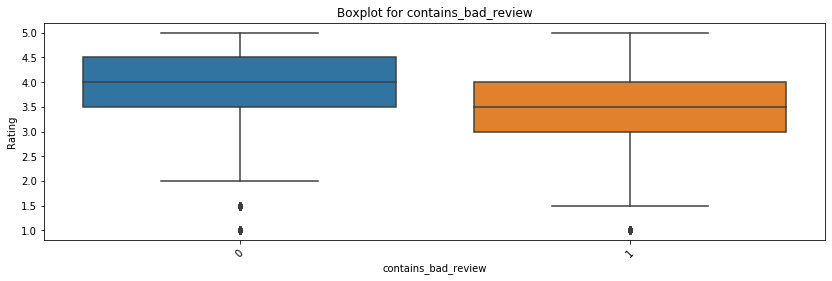

contains_good_review
0    3.916548
1    4.062235
Name: Rating, dtype: float64


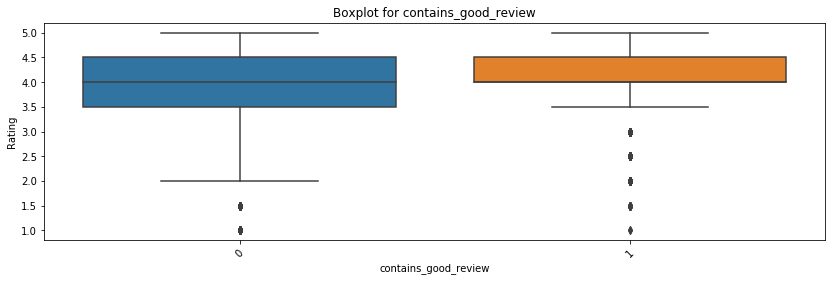

Vegetarian Friendly
0    3.939572
1    4.130709
Name: Rating, dtype: float64


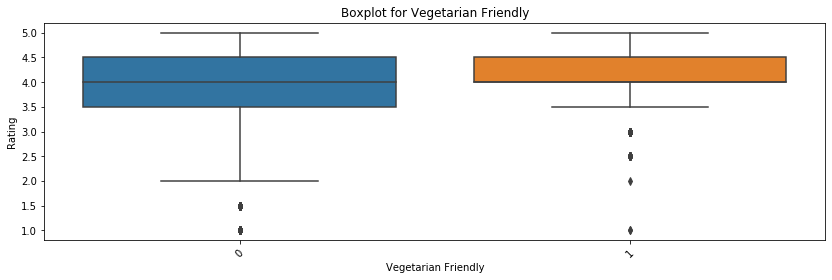

European
0    3.973804
1    4.049332
Name: Rating, dtype: float64


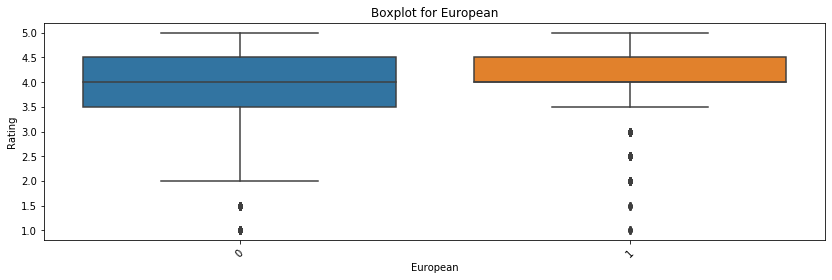

no_style_provided
0    4.007097
1    3.946515
Name: Rating, dtype: float64


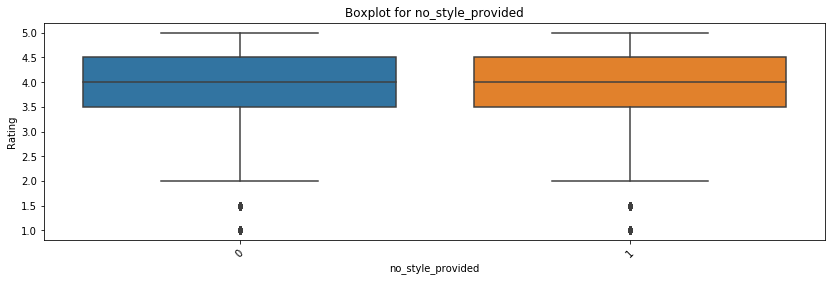

Mediterranean
0    3.978427
1    4.071531
Name: Rating, dtype: float64


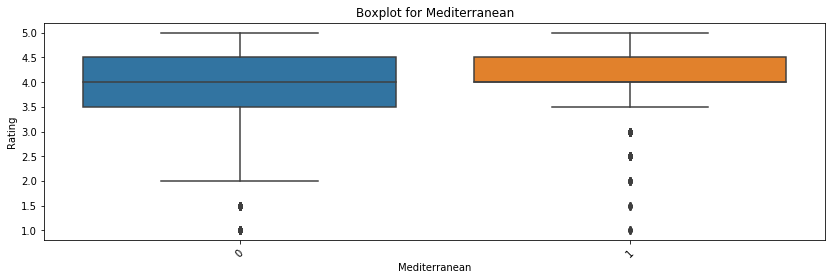

Italian
0    3.986749
1    4.028924
Name: Rating, dtype: float64


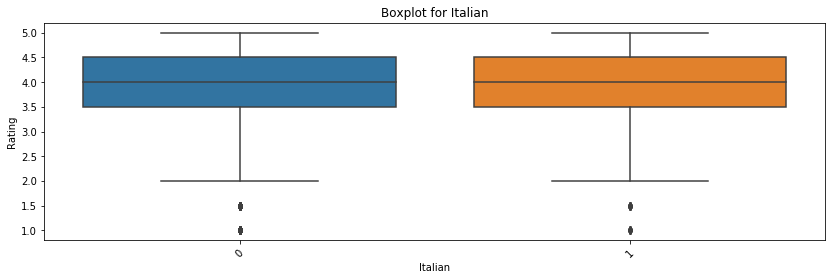

Vegan Options
0    3.964042
1    4.222581
Name: Rating, dtype: float64


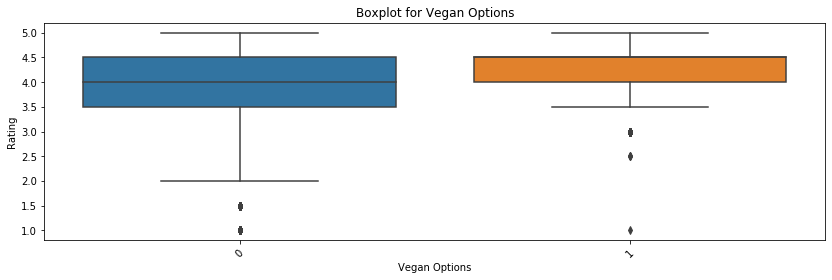

Gluten Free Options
0    3.970533
1    4.189399
Name: Rating, dtype: float64


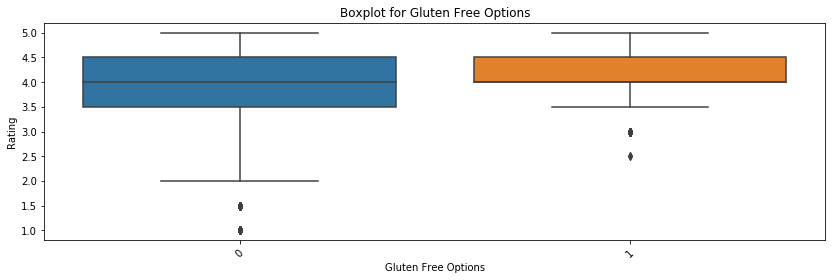

Bar
0    3.991630
1    4.004611
Name: Rating, dtype: float64


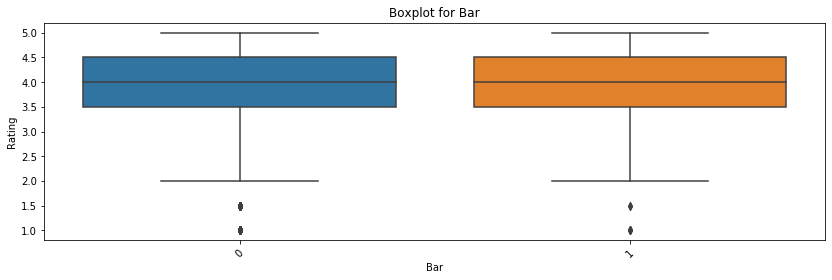

French
0    3.990465
1    4.022727
Name: Rating, dtype: float64


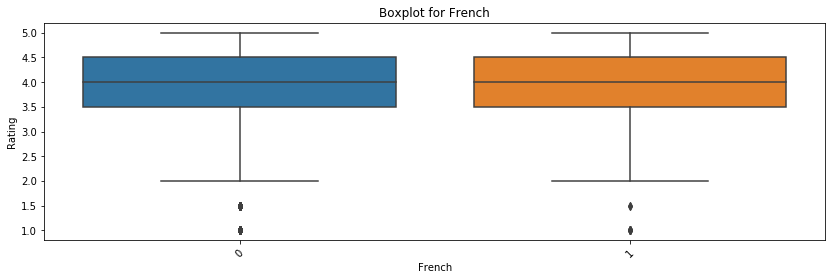

Asian
0    3.993808
1    3.983588
Name: Rating, dtype: float64


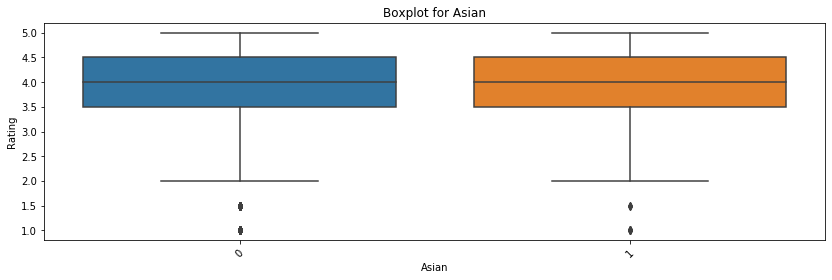

capital
0.0    3.975324
1.0    3.999078
Name: Rating, dtype: float64


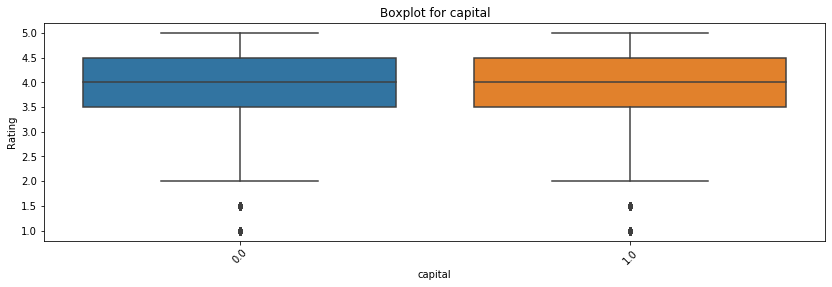

average
0.0    4.113152
1.0    3.964394
Name: Rating, dtype: float64


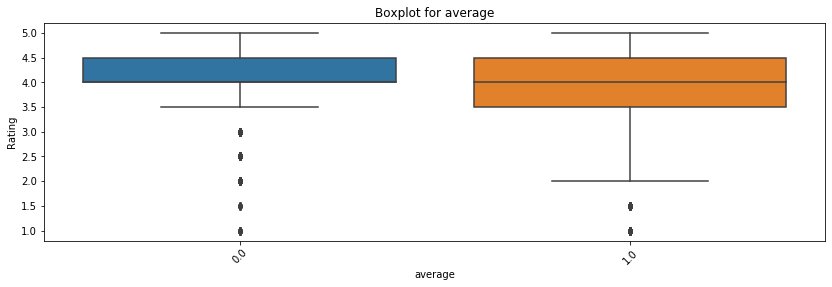

high
0.0    3.985224
1.0    4.204849
Name: Rating, dtype: float64


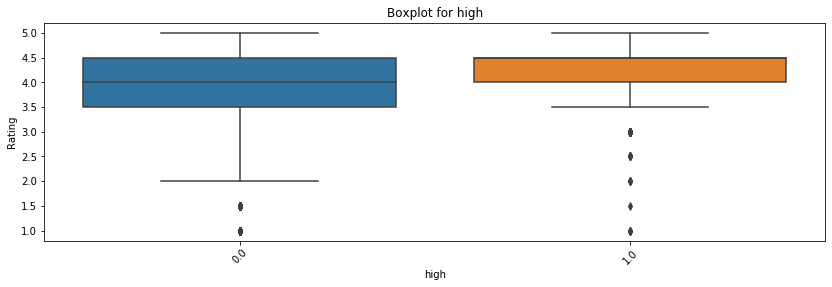

low
0.0    3.974541
1.0    4.092371
Name: Rating, dtype: float64


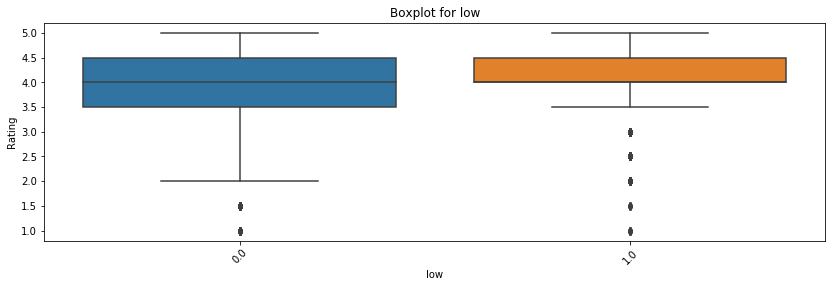

is_weekend
0    3.995507
1    3.980812
Name: Rating, dtype: float64


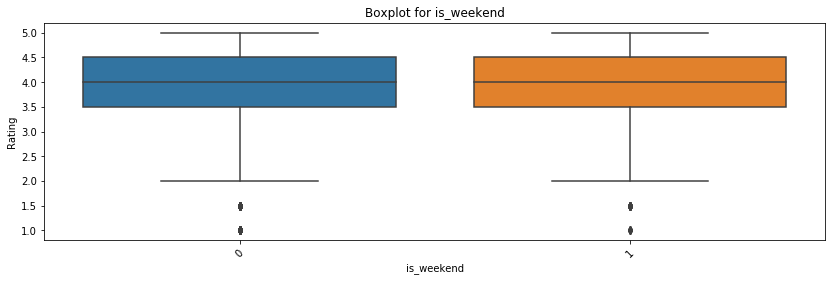

In [110]:
# visual assessment of categorical variables
for c in categorical:
    fig, ax = plt.subplots(figsize=(14, 4))
    sns.boxplot(x=c, y=df['Rating'], data=df, ax=ax)
    means = df.groupby(c)['Rating'].mean()
    print(means)
    plt.xticks(rotation=45)
    ax.set_title('Boxplot for ' + c)
    plt.show() 

In [111]:
# lets find statistically insignificant categorical variables
# (average ratings for these variables do not differ much based
# on their value)
insignificant = []
for c in categorical:
    if get_stat_dif(c, df) != c:
        insignificant.append(c)

df.drop(labels=insignificant, inplace=True, axis=1)
print(f"\nInsignificant columns {insignificant} dropped!")
df.head(10)

Statistically significant differences found for column: contains_bad_review
Statistically significant differences found for column: contains_good_review
Statistically significant differences found for column: Vegetarian Friendly
Statistically significant differences found for column: European
Statistically significant differences found for column: no_style_provided
Statistically significant differences found for column: Mediterranean
Statistically significant differences found for column: Italian
Statistically significant differences found for column: Vegan Options
Statistically significant differences found for column: Gluten Free Options
Statistically significant differences found for column: French
Statistically significant differences found for column: capital
Statistically significant differences found for column: average
Statistically significant differences found for column: high
Statistically significant differences found for column: low

Insignificant columns ['Bar', 'Asian', 

,Ranking,Rating,Number of Reviews,contains_bad_review,contains_good_review,cuisine_styles_num,Vegetarian Friendly,European,no_style_provided,Mediterranean,...,Vegan Options,Gluten Free Options,French,capital,population,average,high,low,restaurant_age,median_interval
0,5570.0,3.5,194.0,0,1,3,0,1,0,0,...,0,0,1,1.0,9904000.0,1.0,0.0,0.0,2362,622.0
1,1537.0,4.0,10.0,0,0,0,0,0,1,0,...,0,0,0,1.0,1264000.0,1.0,0.0,0.0,0,0.0
2,353.0,4.5,688.0,0,0,7,1,0,0,0,...,1,1,0,1.0,8567000.0,0.0,1.0,0.0,1411,8.0
3,3458.0,5.0,3.0,0,0,0,0,0,1,0,...,0,0,0,1.0,3406000.0,1.0,0.0,0.0,0,0.0
4,621.0,4.0,84.0,0,1,3,1,1,0,0,...,0,0,0,0.0,1275000.0,1.0,0.0,0.0,1327,566.0
5,1419.0,3.0,2.0,0,1,0,0,0,1,0,...,0,0,0,0.0,1337000.0,1.0,0.0,0.0,271,54.0
6,1722.0,4.0,50.0,0,1,2,0,0,0,0,...,0,0,0,0.0,2945000.0,0.0,0.0,1.0,1250,192.0
7,826.0,3.0,9.0,0,1,1,0,0,0,0,...,0,0,0,1.0,423737.0,1.0,0.0,0.0,0,0.0
8,2692.0,4.0,0.0,0,0,0,0,0,1,0,...,0,0,0,1.0,2400000.0,1.0,0.0,0.0,0,0.0
9,4210.0,4.0,55.0,0,1,3,0,0,0,0,...,0,0,0,1.0,3339000.0,0.0,0.0,1.0,965,485.0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000250248BC608>,
      dtype=object)

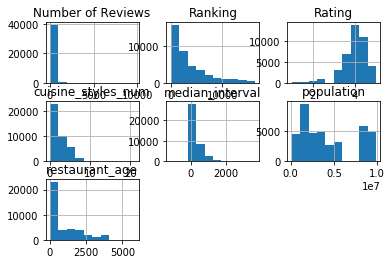

In [112]:
# visual assessment of numeric variables
df[numeric].hist()

In [113]:
# building a corelation matrix
df[numeric].corr()

,Ranking,Number of Reviews,cuisine_styles_num,restaurant_age,median_interval,population,Rating
Ranking,1.000000,-0.222072,-0.313208,-0.182401,-0.076189,0.681709,-0.368371
Number of Reviews,-0.222072,1.000000,0.399564,0.435012,0.083358,0.017949,0.026924
cuisine_styles_num,-0.313208,0.399564,1.000000,0.496285,0.296948,-0.041161,0.113886
restaurant_age,-0.182401,0.435012,0.496285,1.000000,0.679109,0.052040,-0.047891
median_interval,-0.076189,0.083358,0.296948,0.679109,1.000000,0.037997,-0.060763
population,0.681709,0.017949,-0.041161,0.052040,0.037997,1.000000,-0.059917
Rating,-0.368371,0.026924,0.113886,-0.047891,-0.060763,-0.059917,1.000000


In [114]:
# # let's make the distribution of numeric variables a bit closer to normal
# # by taking a square root of each value
# for c in without_target:
#     df[c] = np.sqrt(df[c])

# # let's scale numeric variables using a standard scaler
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# df_scaled = pd.DataFrame(scaler.fit_transform(df[without_target]), columns=without_target)
# df.drop(labels=without_target,inplace=True,axis=1)
# df = pd.concat([df,df_scaled], axis = 1)
# df.head()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000250248D0B08>,
      dtype=object)

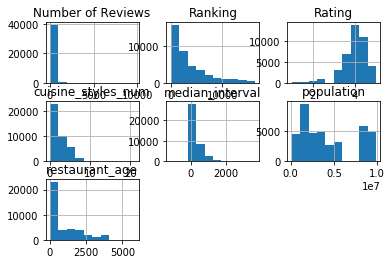

In [115]:
# visual assessment of numeric variables after normalization and scaling
df[numeric].hist()

In [116]:
#df.drop(['contains_good_review', 'contains_bad_review', 'Vegetarian Friendly', \
#          'European', 'no_style_provided', 'Mediterranean', 'Italian', 'Vegan Options',\
#          'Gluten Free Options','French'], axis=1, inplace=True)

#df.drop(['median_interval','restaurant_age'], axis=1, inplace=True)

# Разбиваем датафрейм на части, необходимые для обучения и тестирования модели

In [117]:
# Х - данные с информацией о ресторанах, у - целевая переменная (рейтинги ресторанов)
#X = df.drop(['Restaurant_id', 'Rating'], axis = 1)
X = df.drop(['Rating'], axis = 1)
y = df['Rating']

In [118]:
# Загружаем специальный инструмент для разбивки:
from sklearn.model_selection import train_test_split

In [119]:
# Наборы данных с меткой "train" будут использоваться для обучения модели, "test" - для тестирования.
# Для тестирования мы будем использовать 25% от исходного датасета.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

# Создаём, обучаем и тестируем модель

In [120]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [121]:
# Создаём модель
regr = RandomForestRegressor(n_estimators=100)

# Обучаем модель на тестовом наборе данных
regr.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = regr.predict(X_test)

In [122]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.21304049999999997
